In [0]:
displayHTML('''<center><br> <img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Amazon_2024.svg" style="width: 200px;"></center><br>''')

In [0]:
displayHTML('''<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color: #d9345b;">BDA Project |</span> <span style="color: #2a2a83;">Sentiment Analysis on Amazon Reviews of Electronics</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Filipa Pereira, 20240509</div>
            <div>João Henriques, 20240499</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>
''')

BDA Project | Sentiment Analysis on Amazon Reviews of Electronics 
 
 
 Spring Semester | 2024 - 2025
 
 
 Master in Data Science and Advanced Analytics
 
 
 André Silvestre, 20240502 
 Filipa Pereira, 20240509 
 João Henriques, 20240499 
 Umeima Mahomed, 20240543 
 
 
 Group 37

In [0]:
displayHTML('''
<div style="background: linear-gradient(to right, #f79a06, #d9345b, #113d7c, #3d1c87);
            padding: 7px; color: white; border-radius: 500px; text-align: center;">
</div>
''')

In [0]:
# EXCLUSIVELY FOR DATABRICKS
#       (Solve the issue of "ValueError: Only supported for TrueType fonts' - WordCloud")
!pip install --upgrade pip
!pip install --upgrade Pillow
!pip install wordcloud

# Restart the Python process to make sure the new libraries are loaded
dbutils.library.restartPython()

     |████████████████████████████████| 1.8 MB 7.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 87.6 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.0.1
    Not uninstalling pillow at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-9bf121ac-96e0-4ff7-8ed3-7016795553f8
    Can't uninstall 'Pillow'. No files were found to uninstall.


### **PySpark Session**

In [0]:
from pyspark.sql import SparkSession, DataFrame

# Initialize Spark Session with optimized configurations
# Source: https://spark.apache.org/docs/latest/configuration.html
spark = (SparkSession.builder
         .appName("AmazonReviewsBigDataAnalytics_TextAnalysis")
         .config("spark.driver.memory", "15g")              # Adjust memory for driver
         .config("spark.executor.memory", "15g")            # Adjust memory per executor
         .getOrCreate())

# Set Spark configurations for convert to Pandas without errors
# Source: https://stackoverflow.com/questions/47536123/collect-or-topandas-on-a-large-dataframe-in-pyspark-emr
#         https://stackoverflow.com/questions/50958721/convert-a-spark-dataframe-to-pandas-df
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## 📚 **Libraries Import**

In [0]:
# Imports for System Operations
import os
import sys
import time
import datetime

# Imports for Data Manipulation
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Imports for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Imports PySpark
import pyspark.sql.types as T
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.types import *

# Imports for Text Processing
from pyspark.ml import Pipeline
from pyspark.sql.functions import explode, split, lower, regexp_replace, col, count, desc
from pyspark.ml.feature import Tokenizer, StopWordsRemover, NGram

# Imports for Word Cloud Generation
from wordcloud import WordCloud

---

## 🧮 **Import Databases**

### **🟥 Databricks FileStore**

- If you are using Databricks, you can just use the following code to import the dataset:
    - Otherwise, you replace **`%sh`** with **`!`** and run the command in your terminal. Don't forget to replace the path with your local path.


In [0]:
%sh
# Create the directory for the dataset
mkdir -p /databricks/driver/AfterPreprocessing

# Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# Step 1: Fetch the confirmation token and save cookies (Reviews)
wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Step 2: Read the confirmation token
confirm_token=$(cat /tmp/confirm.txt)

# Step 3: Download the file using the confirmation token and cookies, with the desired filename (Reviews)
wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download&confirm=$confirm_token" \
  -O /databricks/driver/AfterPreprocessing/df-computers-reviews.zip

# Step 4: Clean up temporary files
rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-31 08:11:17--  https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.33.65, 2607:f8b0:400a:800::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.33.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198851642 (190M) [application/octet-stream]
Saving to: ‘/databricks/driver/AfterPreprocessing/df-computers-reviews.zip’

     0K .......... .......... .......... .......... ..........  0% 4.23M 45s
    50K .......... .......... .......... .......... ..........  0% 7.42M 35s
   100K .......... .......... .......... .......... ..........  0% 6.54M 33s
   150K .......... .......... .......... .......... ..........  0% 10.1M 30s
   200K .......... .......... .......... .......... ..........  0% 26.7M 25s
   250K .......... .......... .......... .......... ..........  0% 16.6M 23s
   300K .

In [0]:
%sh
# Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# Step 1: Fetch the confirmation token and save cookies (Products)
wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Step 2: Read the confirmation token
confirm_token=$(cat /tmp/confirm.txt)

# Step 3: Download the file using the confirmation token and cookies, with the desired filename (Products)
wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&export=download&confirm=$confirm_token" \
  -O /databricks/driver/AfterPreprocessing/df-computers-products.zip

# Step 4: Clean up temporary files
rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-31 08:11:30--  https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&export=download&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.33.65, 2607:f8b0:400a:800::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.33.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5532593 (5.3M) [application/octet-stream]
Saving to: ‘/databricks/driver/AfterPreprocessing/df-computers-products.zip’

     0K .......... .......... .......... .......... ..........  0% 2.65M 2s
    50K .......... .......... .......... .......... ..........  1% 5.06M 1s
   100K .......... .......... .......... .......... ..........  2% 5.82M 1s
   150K .......... .......... .......... .......... ..........  3% 7.16M 1s
   200K .......... .......... .......... .......... ..........  4% 16.5M 1s
   250K .......... .......... .......... .......... ..........  5% 10.2M 1s
   300K ........

In [0]:
%sh
# Print the contents of the driver directory
ls -lh /databricks/driver/

total 1.3M
drwxr-xr-x 2 root root 4.0K May 31 08:11 AfterPreprocessing
drwxr-xr-x 2 root root 4.0K May 31 07:01 azure
drwxr-xr-x 2 root root 4.0K May 31 07:01 conf
drwxr-xr-x 3 root root 4.0K May 31 08:06 eventlogs
-r-xr-xr-x 1 root root 2.7K May 31 07:01 hadoop_accessed_config.lst
drwxr-xr-x 2 root root 4.0K May 31 08:06 logs
-r-xr-xr-x 1 root root 1.3M May 31 07:01 preload_class.lst


In [0]:
%sh
# Unzip the downloaded files
unzip  /databricks/driver/AfterPreprocessing/df-computers-reviews.zip -d  /databricks/driver/AfterPreprocessing/df-computers-reviews
unzip  /databricks/driver/AfterPreprocessing/df-computers-products.zip -d  /databricks/driver/AfterPreprocessing/df-computers-products

# List the unzipped files
ls -lh  /databricks/driver/AfterPreprocessing/

Archive:  /databricks/driver/AfterPreprocessing/df-computers-reviews.zip
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/.part-00000-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet.crc  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/part-00001-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/.part-00001-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet.crc  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/.part-00004-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet.crc  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/_SUCCESS  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/part-00000-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/.part-00003-4fd96304-fb62-4356-94dd-38d196ae095

### **🟨 Google Colab/Locally FileStore**

- If you are using Google Colab or running the notebook locally, you can use the following code to download the dataset.

In [0]:
# # Create a directory for the data
# !mkdir -p /content/AfterPreprocessing/

In [0]:
# # Download the file from Google Drive using wget
# # Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# # Download the file using the confirmation token and cookies (Reviews)
# !wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
#   "https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download" -O- | \
#   sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# # Read the confirmation token from the temporary file
# with open('/tmp/confirm.txt', 'r') as f:
#     confirm_token = f.read().strip()

# # Download the file using the confirmation token and cookies (Reviews)
# !wget --load-cookies /tmp/cookies.txt \
#   "https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download&confirm={confirm_token}" \
#   -O /content/AfterPreprocessing/df-computers-reviews.zip

# # Clean up temporary files
# !rm /tmp/cookies.txt /tmp/confirm.txt

In [0]:
# # Download the file using the confirmation token and cookies (Products)
# !wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
#   "https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&export=download" -O- | \
#   sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# # Read the confirmation token from the temporary file
# with open('/tmp/confirm.txt', 'r') as f:
#     confirm_token = f.read().strip()

# # Download the file using the confirmation token and cookies (Products)
# !wget --load-cookies /tmp/cookies.txt \
#   "https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&confirm={confirm_token}" \
#   -O /content/AfterPreprocessing/df-computers-products.zip

# # Clean up temporary files
# !rm /tmp/cookies.txt /tmp/confirm.txt

In [0]:
# # List files in the /content directory to verify the download
# !ls -lh /content/

# # Unzip the downloaded file
# !unzip /content/AfterPreprocessing/df-computers-reviews.zip -d /content/AfterPreprocessing/df-computers-reviews
# !unzip /content/AfterPreprocessing/df-computers-products.zip -d /content/AfterPreprocessing/df-computers-products

# # List the unzipped files to verify
# !ls -lh /content/AfterPreprocessing/

---

### **🧮 PySpark Load Data**

In [0]:
# Import Data (Products and Reviews from Amazon since 2022 - Electronics.Computers | After Preprocessing)

# Read the reviews DataFrame
# reviews_df = spark.read.parquet("./data/AfterPreprocessing/df-computers-reviews")                   # Local Path
reviews_df = spark.read.parquet("file:/databricks/driver/AfterPreprocessing/df-computers-reviews")  # Databricks Path
# reviews_df = spark.read.parquet("/content/AfterPreprocessing/df-computers-reviews")                 # Google Colab Path

# Read the products/metadata DataFrame
# products_df = spark.read.parquet("./data/AfterPreprocessing/df-computers-products")                  # Local Path
products_df = spark.read.parquet("file:/databricks/driver/AfterPreprocessing/df-computers-products")  # Databricks Path
# products_df = spark.read.parquet("/content/AfterPreprocessing/df-computers-products")                # Google Colab Path

### **Reviews**

In [0]:
# Verification of the first observation and schema (Reviews)
reviews_df.printSchema()
reviews_df.show(1, vertical=True)

# Number of Observations and Features
print("\n\033[1mNumber of Observations:\033[0m ", reviews_df.count())
print("\033[1mNumber of Features:\033[0m ", len(reviews_df.columns))

root
 |-- review_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- timestamp_dt: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)

-RECORD 0----------------------------
 review_id    | 889442               
 rating       | 1                    
 review_text  | Arrived without d... 
 parent_asin  | B07FP8VLXS           
 user_id      | AF4QU6OZEHBMIYPVB... 
 helpful_vote | 0                    
 timestamp    | 1677010612293        
 timestamp_dt | 2023-02-21 20:16:52  
 year         | 2023                 
 month        | 2                    
 day          | 21                   
 day_of_week

### **Products/Metadata**

In [0]:
# Verification of the first observation and schema (Products)
products_df.printSchema()
products_df.show(1, vertical=True)

# Number of Observations and Features
print("\n\033[1mNumber of Observations:\033[0m ", products_df.count())
print("\033[1mNumber of Features:\033[0m ", len(products_df.columns))

root
 |-- meta_title: string (nullable = true)
 |-- meta_average_rating: double (nullable = true)
 |-- meta_rating_number: integer (nullable = true)
 |-- meta_price: double (nullable = true)
 |-- meta_store: string (nullable = true)
 |-- parent_asin: string (nullable = true)

-RECORD 0-----------------------------------
 meta_title          | Barnes & Noble No... 
 meta_average_rating | 4.0                  
 meta_rating_number  | 12                   
 meta_price          | 147.95               
 meta_store          | Barnes & Noble       
 parent_asin         | 0594149290           
only showing top 1 row


Number of Observations:  59418
Number of Features:  6


In [0]:
displayHTML('''
# <span style="color: #ffffff;">3 | Data Preprocessing</span>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #f79a06, #d9345b, #113d7c, #3d1c87);
            padding: 10px; color: white; border-radius: 300px; text-align: center;">
    <center><h1 style="margin-top: 10px; margin-bottom: 4px; color: white;
                       font-size: 32px; font-family: 'Avenir Next LT Pro', sans-serif;">
        <b>3 | Data Preparation</b></h1></center>
</div>

<br>
''')

# 3 | Data Preprocessing 
 


 
 
 3 | Data Preparation

In [0]:
# Color Palette for Data Visualization
color_palette = [
    "#F79A06",  # Vibrant Orange      0
    "#E46D20",  # Burnt Orange        1
    "#D9345B",  # Reddish Pink        2
    "#C32A68",  # Dark Magenta        3
    "#9F1F74",  # Warm Purple         4
    "#731C7E",  # Deep Purple         5
    "#3D1C87",  # Dark Blue-Purple    6
    "#113D7C",  # Intense Blue        7
    "#0C5A9D",  # Vibrant Blue        8
    "#0987C3"   # Light Blue          9
]

In [0]:
displayHTML('''
# <span style="color: #ffffff;">Text Preprocessing</span>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #113D7C;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #113D7C;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>Text Preprocessing</b></h2></center>
</div>
<br>
''')

# Text Preprocessing 
 


 
 Text Preprocessing

## **🔤 Text Pre-Processing and WordCloud Generation**

## **📦 Products/Metadata**

In [0]:
# Check data types of the products 'meta_title' column
products_df.select("meta_title").dtypes

Out[17]: [('meta_title', 'string')]

In [0]:
# 5 sample rows of the 'meta_title' column
products_df.select("meta_title").limit(5).display()

meta_title Barnes & Noble Nook Glowlight 4 eReader | 6" Touchscreen | 32GB | Black | BNRV1100 Barnes & Noble Replacement Charging Sync Cable for Nook HD and HD+ (5 Feet) SanDisk SDSDQUA-064G-A11 Professional Ultra 64GB MicroSDXC card is custom formatted for high speed, lossless recording! Includes Standard SD Adapter. (UHS-1 Class 10 Certified 30MB/sec) for GoPro HERO4 Black Hynix 2GB DDR3 Memory SO-DIMM 204pin PC3-10600S 1333MHz HMT325S6BFR8C-H9-REFURB Professional Ultra SanDisk 64GB MicroSDXC Card for Samsung Galaxy Note 8.0 Smartphone is custom formatted for high speed, lossless recording! Includes Standard SD Adapter. (UHS-1 Class 10 Certified 30MB/sec)

In [0]:
# ========================== Text Processing and Tokenization (meta_title) ==========================
# Start timer
start_time = time.time()

# Define the preprocessing function
def preprocess_text(df, column_name):
    """
    Preprocess the text data by converting to lowercase (lower()),
                                removing HTML tags with regexp_replace ("<[^>]+>", ""),           - Removes text between < and > 
                                removing extra spaces with regexp_replace ("\\s+", " "),          - Keeps one space
                                removing punctuation with regexp_replace ("[^a-zA-Z\\s]", ""),    - Keeps letters and spaces
                                removing tabs, newlines, and all other whitespace characters with regexp_replace
    """
    return df.withColumn("processed_text", lower(col(column_name))) \
             .withColumn("processed_text", regexp_replace(col("processed_text"), "<[^>]+>", "")) \
             .withColumn("processed_text", regexp_replace(col("processed_text"), "\\s+", " ")) \
             .withColumn("processed_text", regexp_replace(col("processed_text"), "[^a-zA-Z\\s]", "")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\\s+", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\t", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\n", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\r", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\f", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\v", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\r\n", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\r\r", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\n\n", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\t\t", " "))

# 1. Preprocessing the text: Lowercase and remove punctuation
#    This improves token quality by treating 'Word' and 'word' the same, etc.
products_text_df = preprocess_text(products_df, "meta_title")

# 2. Tokenization: Split the text into words (tokens) using Spark SQL functions
#    'split' function splits the string by spaces and creates an array of words.
tokenizer = Tokenizer(inputCol="processed_text", outputCol="tokens_array")

# 3. Define the Stopword Removal - Remove common English stopwords (like 'the', 'a', 'is')
remover = StopWordsRemover(inputCol="tokens_array", outputCol="filtered_tokens_array")

# 4. Create the pipeline (best practice for chaining multiple transformations)
pipeline = Pipeline(stages=[tokenizer, remover])

# 5. Fit and transform the data using the pipeline
pipeline_model = pipeline.fit(products_text_df)
processed_df = pipeline_model.transform(products_text_df)

# 6. Explode the filtered tokens array into separate rows
#    This creates a new row for each token in the array, allowing for easier counting.
exploded_df = processed_df.select(explode(col("filtered_tokens_array")).alias("token")) \
                          .filter(col("token") != "") \
                          .filter(col("token").isNotNull())

# 7. Count token frequencies, grouping by the token column
token_counts_df = exploded_df.groupBy("token").agg(count("*").alias("frequency"))

# 8. Order by frequency to see the most common tokens
sorted_token_counts_df = token_counts_df.orderBy(desc("frequency"))

# Show the results (e.g., top 20 most common tokens)
print("\n\033[1mMost Common Tokens (Products Meta Title):\033[0m")
sorted_token_counts_df.show(20, truncate=False)

# Get Total and Unique Token Counts
total_tokens = exploded_df.count()
unique_tokens = sorted_token_counts_df.count()

print(f"\n\033[1mTotal Tokens (Approximate):\033[0m {total_tokens}")
print(f"\033[1mUnique Tokens:\033[0m {unique_tokens}")

# End timer and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution:\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)")


Most Common Tokens (Products Meta Title):
+----------+---------+
|token     |frequency|
+----------+---------+
|gb        |23749    |
|laptop    |15083    |
|usb       |13057    |
|case      |12186    |
|inch      |11232    |
|pro       |10705    |
|x         |9301     |
|keyboard  |9087     |
|intel     |8204     |
|ipad      |8145     |
|ssd       |7929     |
|ram       |7805     |
|black     |7604     |
|card      |7378     |
|cable     |7065     |
|windows   |6969     |
|compatible|6910     |
|wifi      |6280     |
|cover     |6259     |
|core      |6223     |
+----------+---------+
only showing top 20 rows


Total Tokens (Approximate): 1078298
Unique Tokens: 49811

Time of Execution: 28.432316780090332 seconds (0:00:28.432317 h)


Since we plan to do a **Clustering Analysis** after completing the **Sentiment & Topic Analysis**, we will create a new variable called **`n_meta_title`** that will contain the number of important tokens for each product title.
- This count will be calculated based on distinct tokens after cleaning the text.

In [0]:
# Create a new column 'n_meta_title' in the products DataFrame with the count of distinct words
products_df = products_df.withColumn("n_meta_title", F.size(F.split(products_df["meta_title"], " ")))

# Check the new column
products_df.select("meta_title", "n_meta_title").limit(5).display()

meta_title n_meta_title Barnes & Noble Nook Glowlight 4 eReader | 6" Touchscreen | 32GB | Black | BNRV1100 16 Barnes & Noble Replacement Charging Sync Cable for Nook HD and HD+ (5 Feet) 14 SanDisk SDSDQUA-064G-A11 Professional Ultra 64GB MicroSDXC card is custom formatted for high speed, lossless recording! Includes Standard SD Adapter. (UHS-1 Class 10 Certified 30MB/sec) for GoPro HERO4 Black 28 Hynix 2GB DDR3 Memory SO-DIMM 204pin PC3-10600S 1333MHz HMT325S6BFR8C-H9-REFURB 9 Professional Ultra SanDisk 64GB MicroSDXC Card for Samsung Galaxy Note 8.0 Smartphone is custom formatted for high speed, lossless recording! Includes Standard SD Adapter. (UHS-1 Class 10 Certified 30MB/sec) 29

In [0]:
# Check the distribution of the number of words in the 'n_meta_title' column
# Get the basic descriptive statistics for n_meta_title
desc_meta_title = products_df.select("n_meta_title").describe()

# Calculate quartiles (Q1, median, Q3) for n_meta_title
quantiles_meta_title = products_df.approxQuantile("n_meta_title", [0.25, 0.5, 0.75], 0.01)

# Create a DataFrame for quartile values with 'meta_title' in names
quartile_data_meta_title = [
    Row(summary="25th percentile (Q1)", n_meta_title=str(quantiles_meta_title[0])),
    Row(summary="50th percentile (Median)", n_meta_title=str(quantiles_meta_title[1])),
    Row(summary="75th percentile (Q3)", n_meta_title=str(quantiles_meta_title[2]))
]

# Convert to DataFrame
quartile_df_meta_title = spark.createDataFrame(quartile_data_meta_title)

# Union the describe result with the quartile results
full_stats_meta_title = desc_meta_title.unionByName(quartile_df_meta_title, allowMissingColumns=True)

# Display the combined result for n_meta_title
full_stats_meta_title.display()

summary n_meta_title count 59418 mean 22.50575583156619 stddev 8.004837778859532 min 1 max 111 25th percentile (Q1) 16.0 50th percentile (Median) 23.0 75th percentile (Q3) 29.0

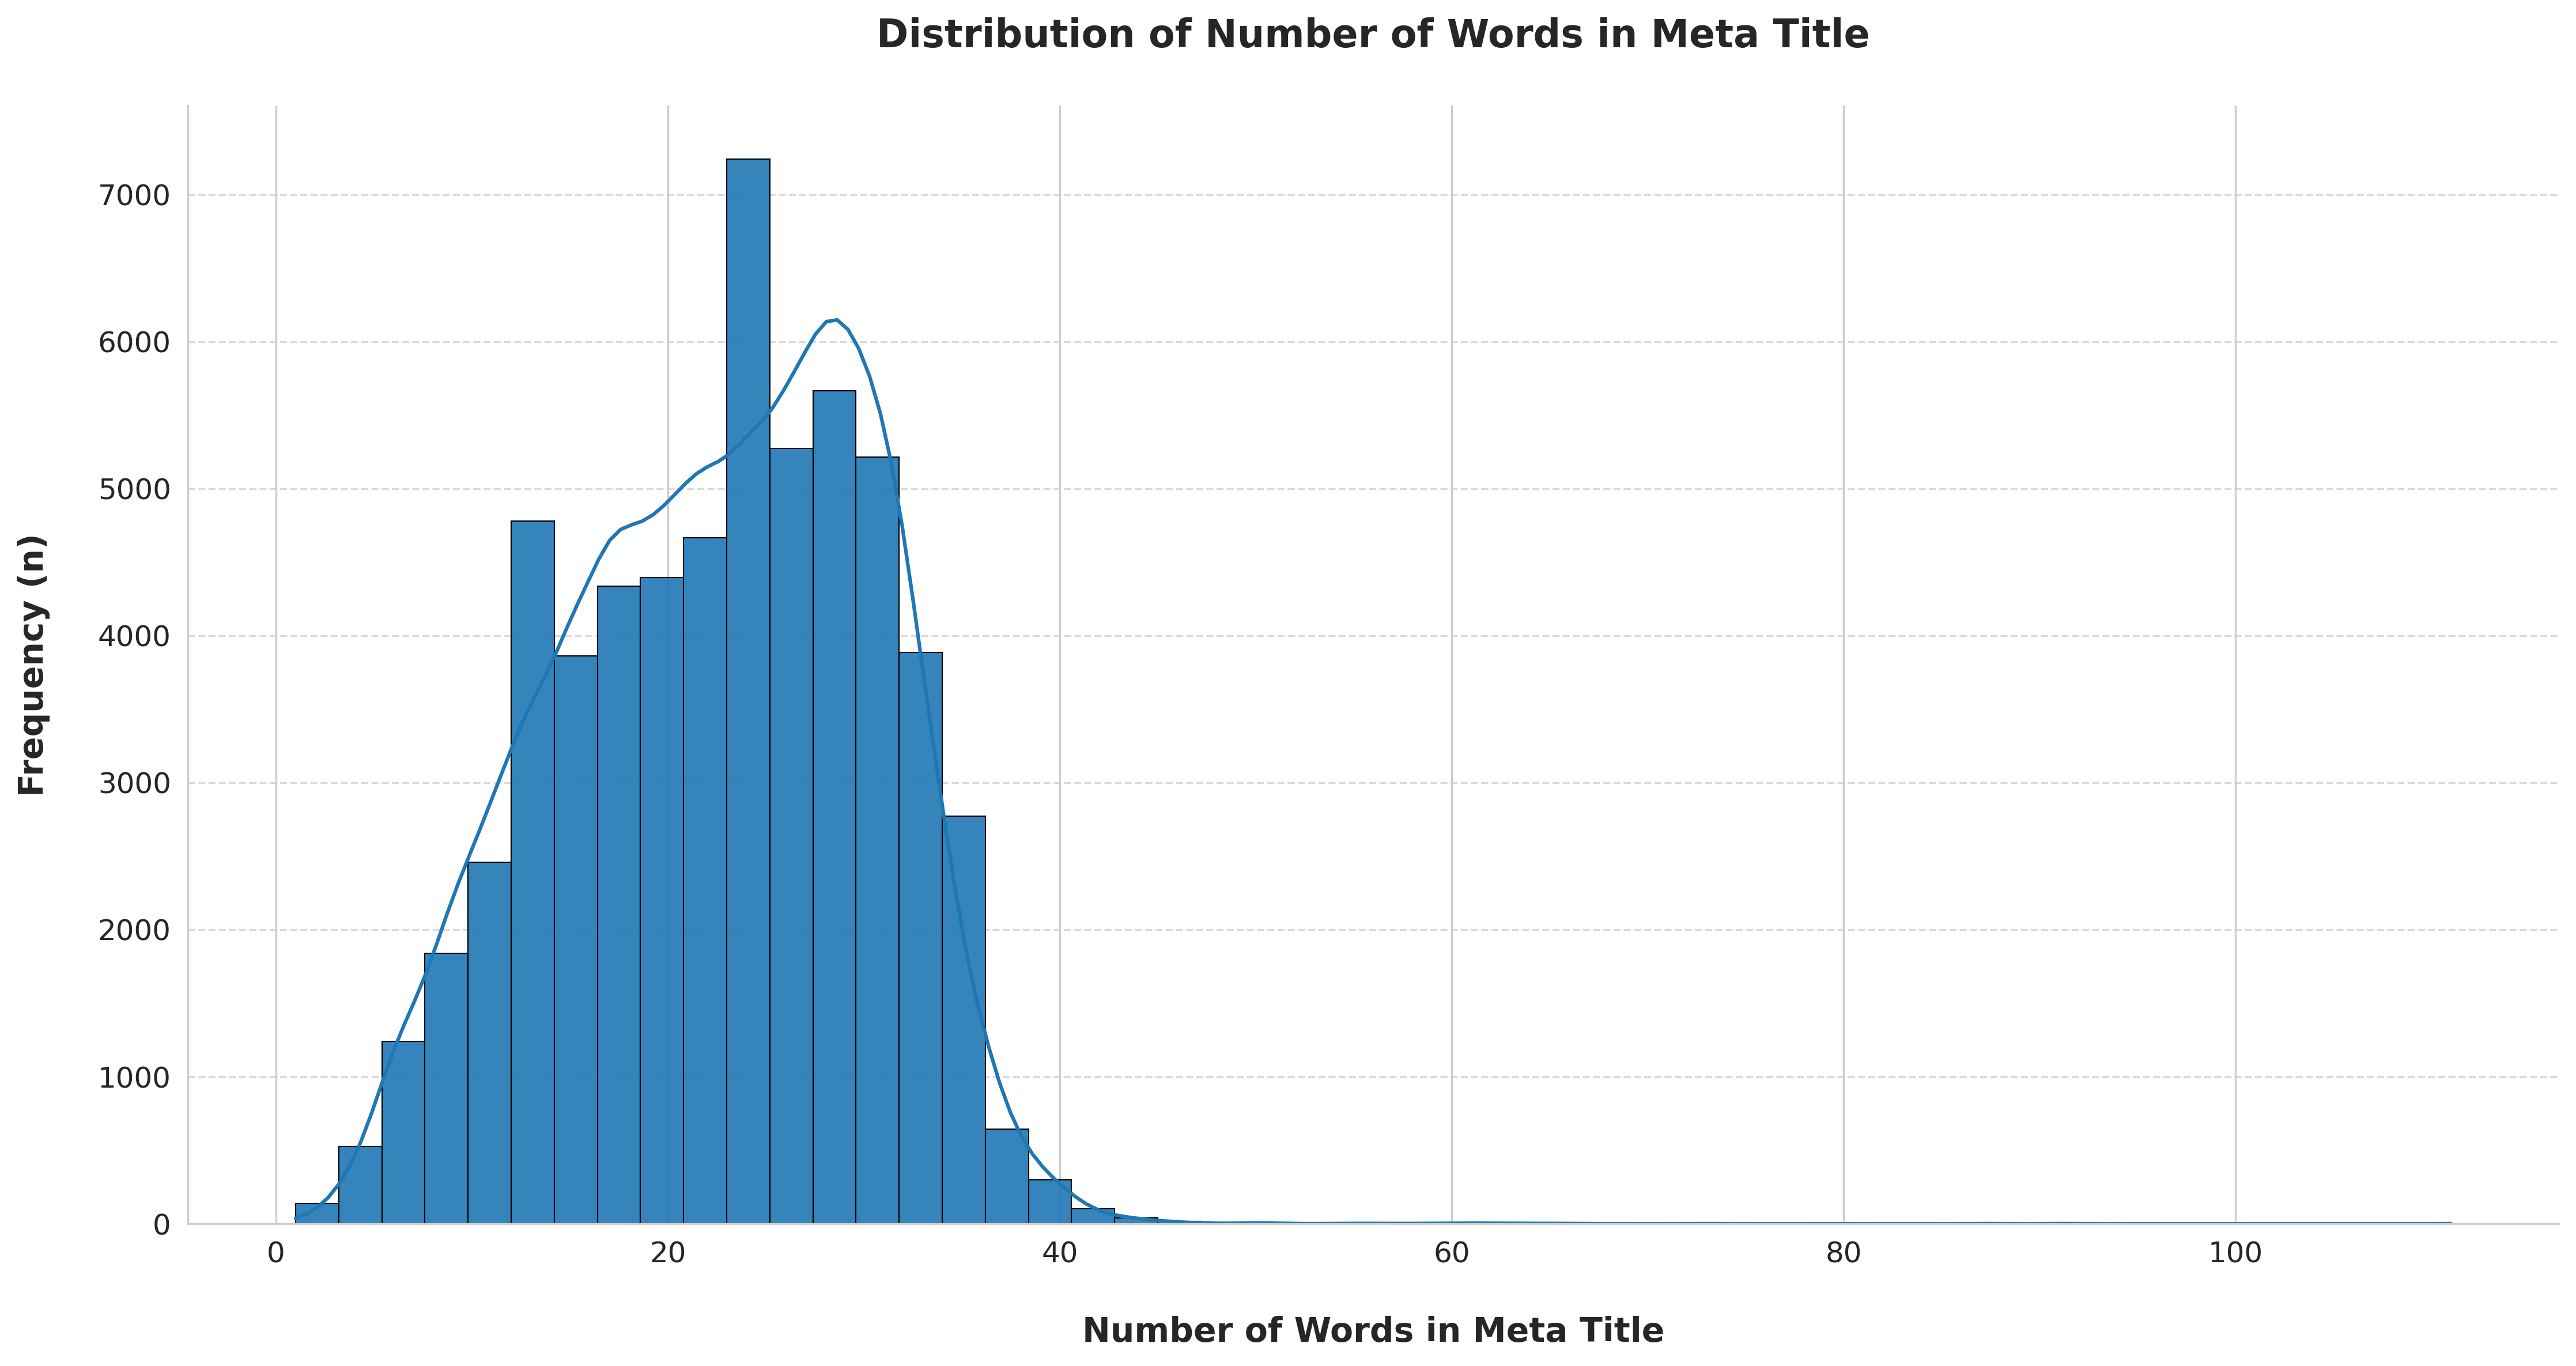

In [0]:
# Histogram of 'n_meta_title' Distribution
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8), dpi=300)
sns.histplot(
    products_df.select("n_meta_title").toPandas(),
    bins=50,
    kde=True,
    color=color_palette[0],
    alpha=0.9,
    edgecolor="black",
    linewidth=0.5
)
plt.title("Distribution of Number of Words in Meta Title\n", fontsize=16, fontweight='bold')
plt.xlabel("\nNumber of Words in Meta Title", fontsize=14, fontweight='bold')
plt.ylabel("Frequency (n)\n", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove legend if it exists
if plt.gca().get_legend() is not None:
    plt.gca().get_legend().remove()

sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

### **🔂 Unigram and 🔗 Bigram Generation**

In [0]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(25, 17), dpi=80)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close()

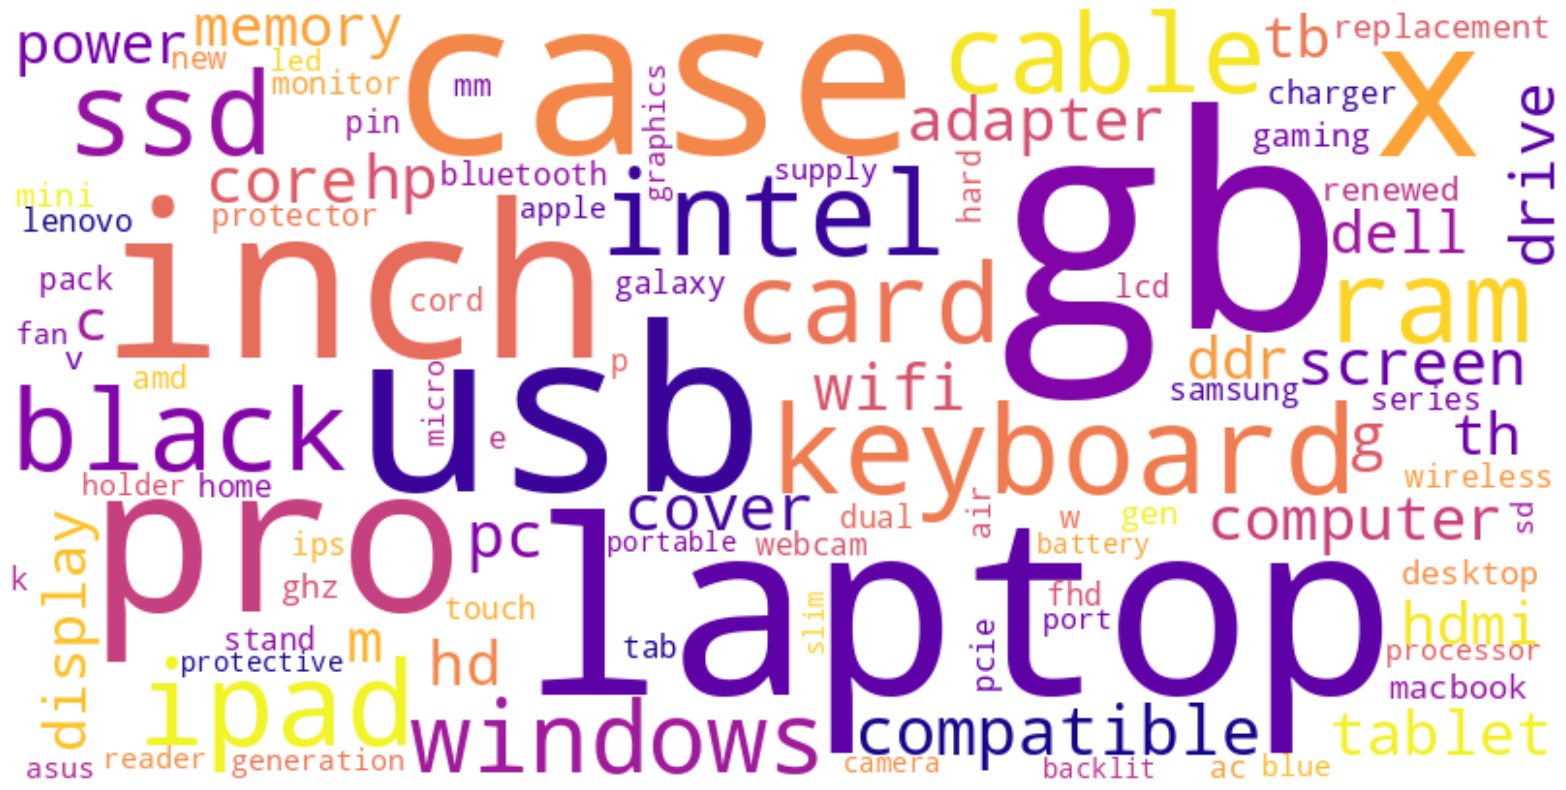


Time of Execution: 7.7964794635772705 seconds (0:00:07.796479 h)


In [0]:
start_time = time.time()

# Collect only a limited number (e.g., 100) for visualization
top_n_unigrams = 100
top_unigrams_collected = sorted_token_counts_df.limit(top_n_unigrams).collect()

# Convert collected Rows into a dictionary
unigrams_freq_dict = {row['token']: row['frequency'] for row in top_unigrams_collected}

# WordCloud Generation (Unigrams)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma') \
                .generate_from_frequencies(unigrams_freq_dict)
plot_cloud(wordcloud)

end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution:\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)")

In [0]:
# WordCloud Generation (Bigram)
# Start timer
start_time = time.time()

# 1. Use the NGram transformer
#    inputCol should be the column containing the ARRAY of tokens
ngram_transformer_bi = NGram(n=2, inputCol="filtered_tokens_array", outputCol="bigrams_array")

# 2. Transform the DataFrame to add the bigram array column
bigrams_df = ngram_transformer_bi.transform(processed_df)

# 3. Explode the bigram array
#    Each element in 'bigrams_array' is a string like "word1 word2" by default
exploded_bigrams_df = bigrams_df.select(explode(col("bigrams_array")).alias("bigram")) \
                                .filter(col("bigram").isNotNull()) \
                                .filter(col("bigram") != "") \
                                .filter(~col("bigram").contains("  ")) \
                                .filter(F.length(col("bigram")) > 2)    # Ensure bigram has meaningful length

# 4. Count bigram frequencies
bigram_counts_df = exploded_bigrams_df.groupBy("bigram").agg(count("*").alias("frequency"))

# 5. Order by frequency
sorted_bigram_counts_df = bigram_counts_df.orderBy(desc("frequency"))

# 6. Show top bigrams
unique_bigrams = sorted_bigram_counts_df.distinct().count()
print(f"\n\033[1mUnique Bigrams:\033[0m {unique_bigrams}")
print("\033[1mMost Common Bigrams:\033[0m")
sorted_bigram_counts_df.show(20, truncate=False)


Unique Bigrams: 253746
Most Common Bigrams:
+----------------+---------+
|bigram          |frequency|
+----------------+---------+
| inch           |8799     |
|windows         |5283     |
|gb ram          |5266     |
|pro             |4459     |
| gb             |4421     |
|usb             |3938     |
|intel core      |3687     |
|ram gb          |3680     |
| pro            |2973     |
|gb ssd          |2932     |
|gb ddr          |2704     |
|laptop          |2351     |
|th gen          |2233     |
|galaxy tab      |2182     |
|macbook pro     |2073     |
|ipad pro        |2019     |
|case            |2010     |
|screen protector|1981     |
| fhd            |1940     |
|power supply    |1938     |
+----------------+---------+
only showing top 20 rows



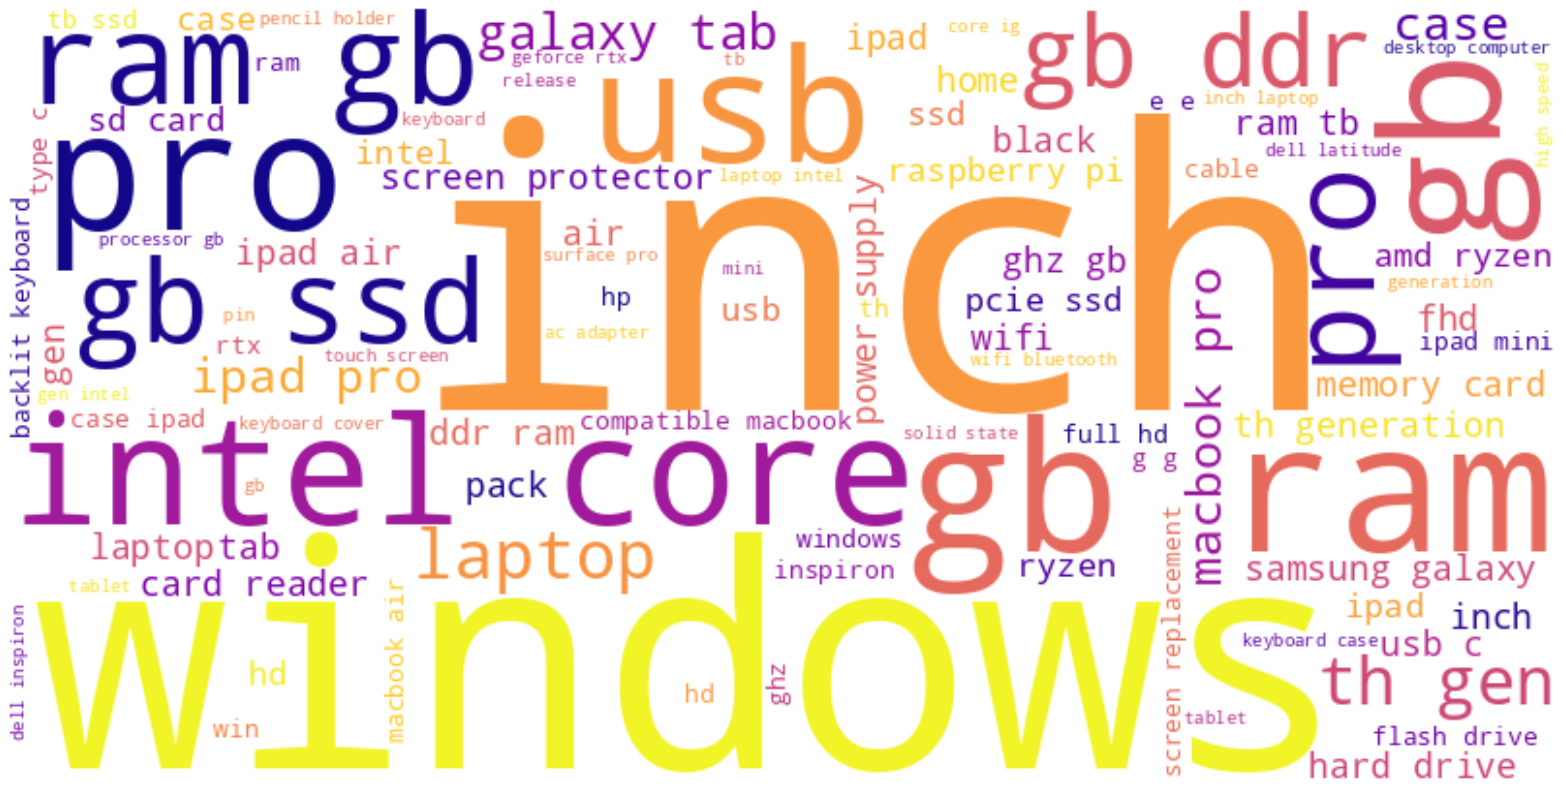


Time of Execution (Bigrams): 34.94756484031677 seconds (0:00:34.947565 h)


In [0]:
# 7. Collect top 100 bigrams for WordCloud
top_n_bigrams = 100
top_bigrams_collected = sorted_bigram_counts_df.limit(top_n_bigrams).collect()

# Convert collected Rows into a dictionary for WordCloud
bigram_freq_dict = {row['bigram']: row['frequency'] for row in top_bigrams_collected}

# WordCloud Generation (Bigram)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma') \
                .generate_from_frequencies(bigram_freq_dict)
plot_cloud(wordcloud)

# End timer and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution (Bigrams):\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)")

---

## **🗨️ Reviews**

In [0]:
# Check data types of the reviews 'review_text' column
reviews_df.select("review_text").dtypes

Out[27]: [('review_text', 'string')]

In [0]:
# 5 sample rows of the 'review_text' column
reviews_df.select("review_text").limit(5).display()

review_text Arrived without dongle. I’ve owned several of these keyboards. This is the first to arrive without the dongle in the slot on the battery cover. It isn’t in the bag, or box. Bottom edges curving up/off screen Definitely makes everything seem a bit more fuzzy/less clear when it is applied to laptop screen. I don't like that the bottom edges are always coming away from the screen. Would not buy again... Great for raspberry pi projects. I use these to install different operating systems on my raspberry pi 3. They work perfectly. Reliable and easy to install Crucial SSDs are great! They always work and they are my first choice for new builds and upgrades. Shattered IPAD My daughter had this on her brand new iPad fresh out of the box. 2 weeks after having it. She dropped it from 2 feet on my hard wood floor and it shattered her tablet. I’m MAD. It’s a brand new iPad and now it’s shattered. I thought these cases were supposed to protect these devices. DO NOT RECOMMEND!!!

In [0]:
# ========================== Text Processing and Tokenization (review_text) ==========================
# Start timer
start_time = time.time()

# Repeat the same preprocessing steps as for products meta_title for the reviews
# 1. Preprocessing the text
reviews_text_df = preprocess_text(reviews_df, "review_text")

# 2. Tokenization
tokenizer = Tokenizer(inputCol="processed_text", outputCol="tokens_array")

# 3. Stopword Removal
remover = StopWordsRemover(inputCol="tokens_array", outputCol="filtered_tokens_array")

# 4. Create the pipeline
pipeline = Pipeline(stages=[tokenizer, remover])

# 5. Fit and transform the data using the pipeline
pipeline_model = pipeline.fit(reviews_text_df)
processed_df = pipeline_model.transform(reviews_text_df)

# 6. Explode the filtered tokens array into separate rows
exploded_df = processed_df.select(explode(col("filtered_tokens_array")).alias("token")) \
                          .filter(col("token") != "") \
                          .filter(col("token").isNotNull())

# Count token frequencies, grouping by the token column
token_counts_df = exploded_df.groupBy("token").agg(count("*").alias("frequency"))

# Order by frequency to see the most common tokens
sorted_token_counts_df = token_counts_df.orderBy(desc("frequency"))

# Show the results (e.g., top 20 most common tokens)
print("\n\033[1mMost Common Tokens (Reviews):\033[0m")
sorted_token_counts_df.show(20, truncate=False)

# Get Total and Unique Token Counts
total_tokens = exploded_df.count()
unique_tokens = sorted_token_counts_df.count()
print(f"\n\033[1mTotal Tokens (Approximate):\033[0m {total_tokens}")
print(f"\033[1mUnique Tokens:\033[0m {unique_tokens}")

# End timer and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution:\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)")


Most Common Tokens (Reviews):
+--------+---------+
|token   |frequency|
+--------+---------+
|great   |391538   |
|good    |250167   |
|works   |225588   |
|one     |209197   |
|use     |203623   |
|work    |169778   |
|case    |169762   |
|like    |162660   |
|product |159437   |
|easy    |152510   |
|well    |144925   |
|laptop  |136857   |
|get     |118430   |
|keyboard|116381   |
|love    |112011   |
|quality |109917   |
|price   |106787   |
|screen  |102632   |
|bought  |95817    |
|nice    |92304    |
+--------+---------+
only showing top 20 rows


Total Tokens (Approximate): 25587857
Unique Tokens: 345245

Time of Execution: 353.07584953308105 seconds (0:05:53.075850 h)


Since we plan to do a **Clustering Analysis** after completing the **Sentiment & Topic Analysis**, we will create a new variable called **`n_reviews_text`** that will contain the number of important tokens for each review.
- This count will be calculated based on distinct tokens after cleaning the text.

In [0]:
# Create a new column 'n_reviews_text' in the reviews DataFrame with the count of distinct words
reviews_df = reviews_df.withColumn("n_reviews_text", F.size(F.split(reviews_df["review_text"], " ")))

# Check the new column
reviews_df.select("review_text", "n_reviews_text").limit(5).display()

review_text n_reviews_text Arrived without dongle. I’ve owned several of these keyboards. This is the first to arrive without the dongle in the slot on the battery cover. It isn’t in the bag, or box. 32 Bottom edges curving up/off screen Definitely makes everything seem a bit more fuzzy/less clear when it is applied to laptop screen. I don't like that the bottom edges are always coming away from the screen. Would not buy again... 39 Great for raspberry pi projects. I use these to install different operating systems on my raspberry pi 3. They work perfectly. 21 Reliable and easy to install Crucial SSDs are great! They always work and they are my first choice for new builds and upgrades. 24 Shattered IPAD My daughter had this on her brand new iPad fresh out of the box. 2 weeks after having it. She dropped it from 2 feet on my hard wood floor and it shattered her tablet. I’m MAD. It’s a brand new iPad and now it’s shattered. I thought these cases were supposed to protect these devices. DO NOT RECOMMEND!!! 61

In [0]:
# Check the distribution of the number of words in the 'n_reviews_text' column
# Get the basic descriptive statistics for n_reviews_text
desc_reviews_text = reviews_df.select("n_reviews_text").describe()

# Calculate quartiles (Q1, median, Q3) for n_reviews_text
quantiles_reviews_text = reviews_df.approxQuantile("n_reviews_text", [0.25, 0.5, 0.75], 0.01)

# Create a DataFrame for quartile values with 'review_text' in names
from pyspark.sql import Row
quartile_data_reviews_text = [
    Row(summary="25th percentile (Q1)", n_reviews_text=str(quantiles_reviews_text[0])),
    Row(summary="50th percentile (Median)", n_reviews_text=str(quantiles_reviews_text[1])),
    Row(summary="75th percentile (Q3)", n_reviews_text=str(quantiles_reviews_text[2]))
]

# Convert to DataFrame
quartile_df_reviews_text = spark.createDataFrame(quartile_data_reviews_text)

# Union the describe result with the quartile results
full_stats_reviews_text = desc_reviews_text.unionByName(quartile_df_reviews_text, allowMissingColumns=True)

# Display the combined result for n_reviews_text
full_stats_reviews_text.display()

summary n_reviews_text count 1085883 mean 45.7703177966687 stddev 59.8139139541348 min 2 max 3942 25th percentile (Q1) 14.0 50th percentile (Median) 28.0 75th percentile (Q3) 55.0

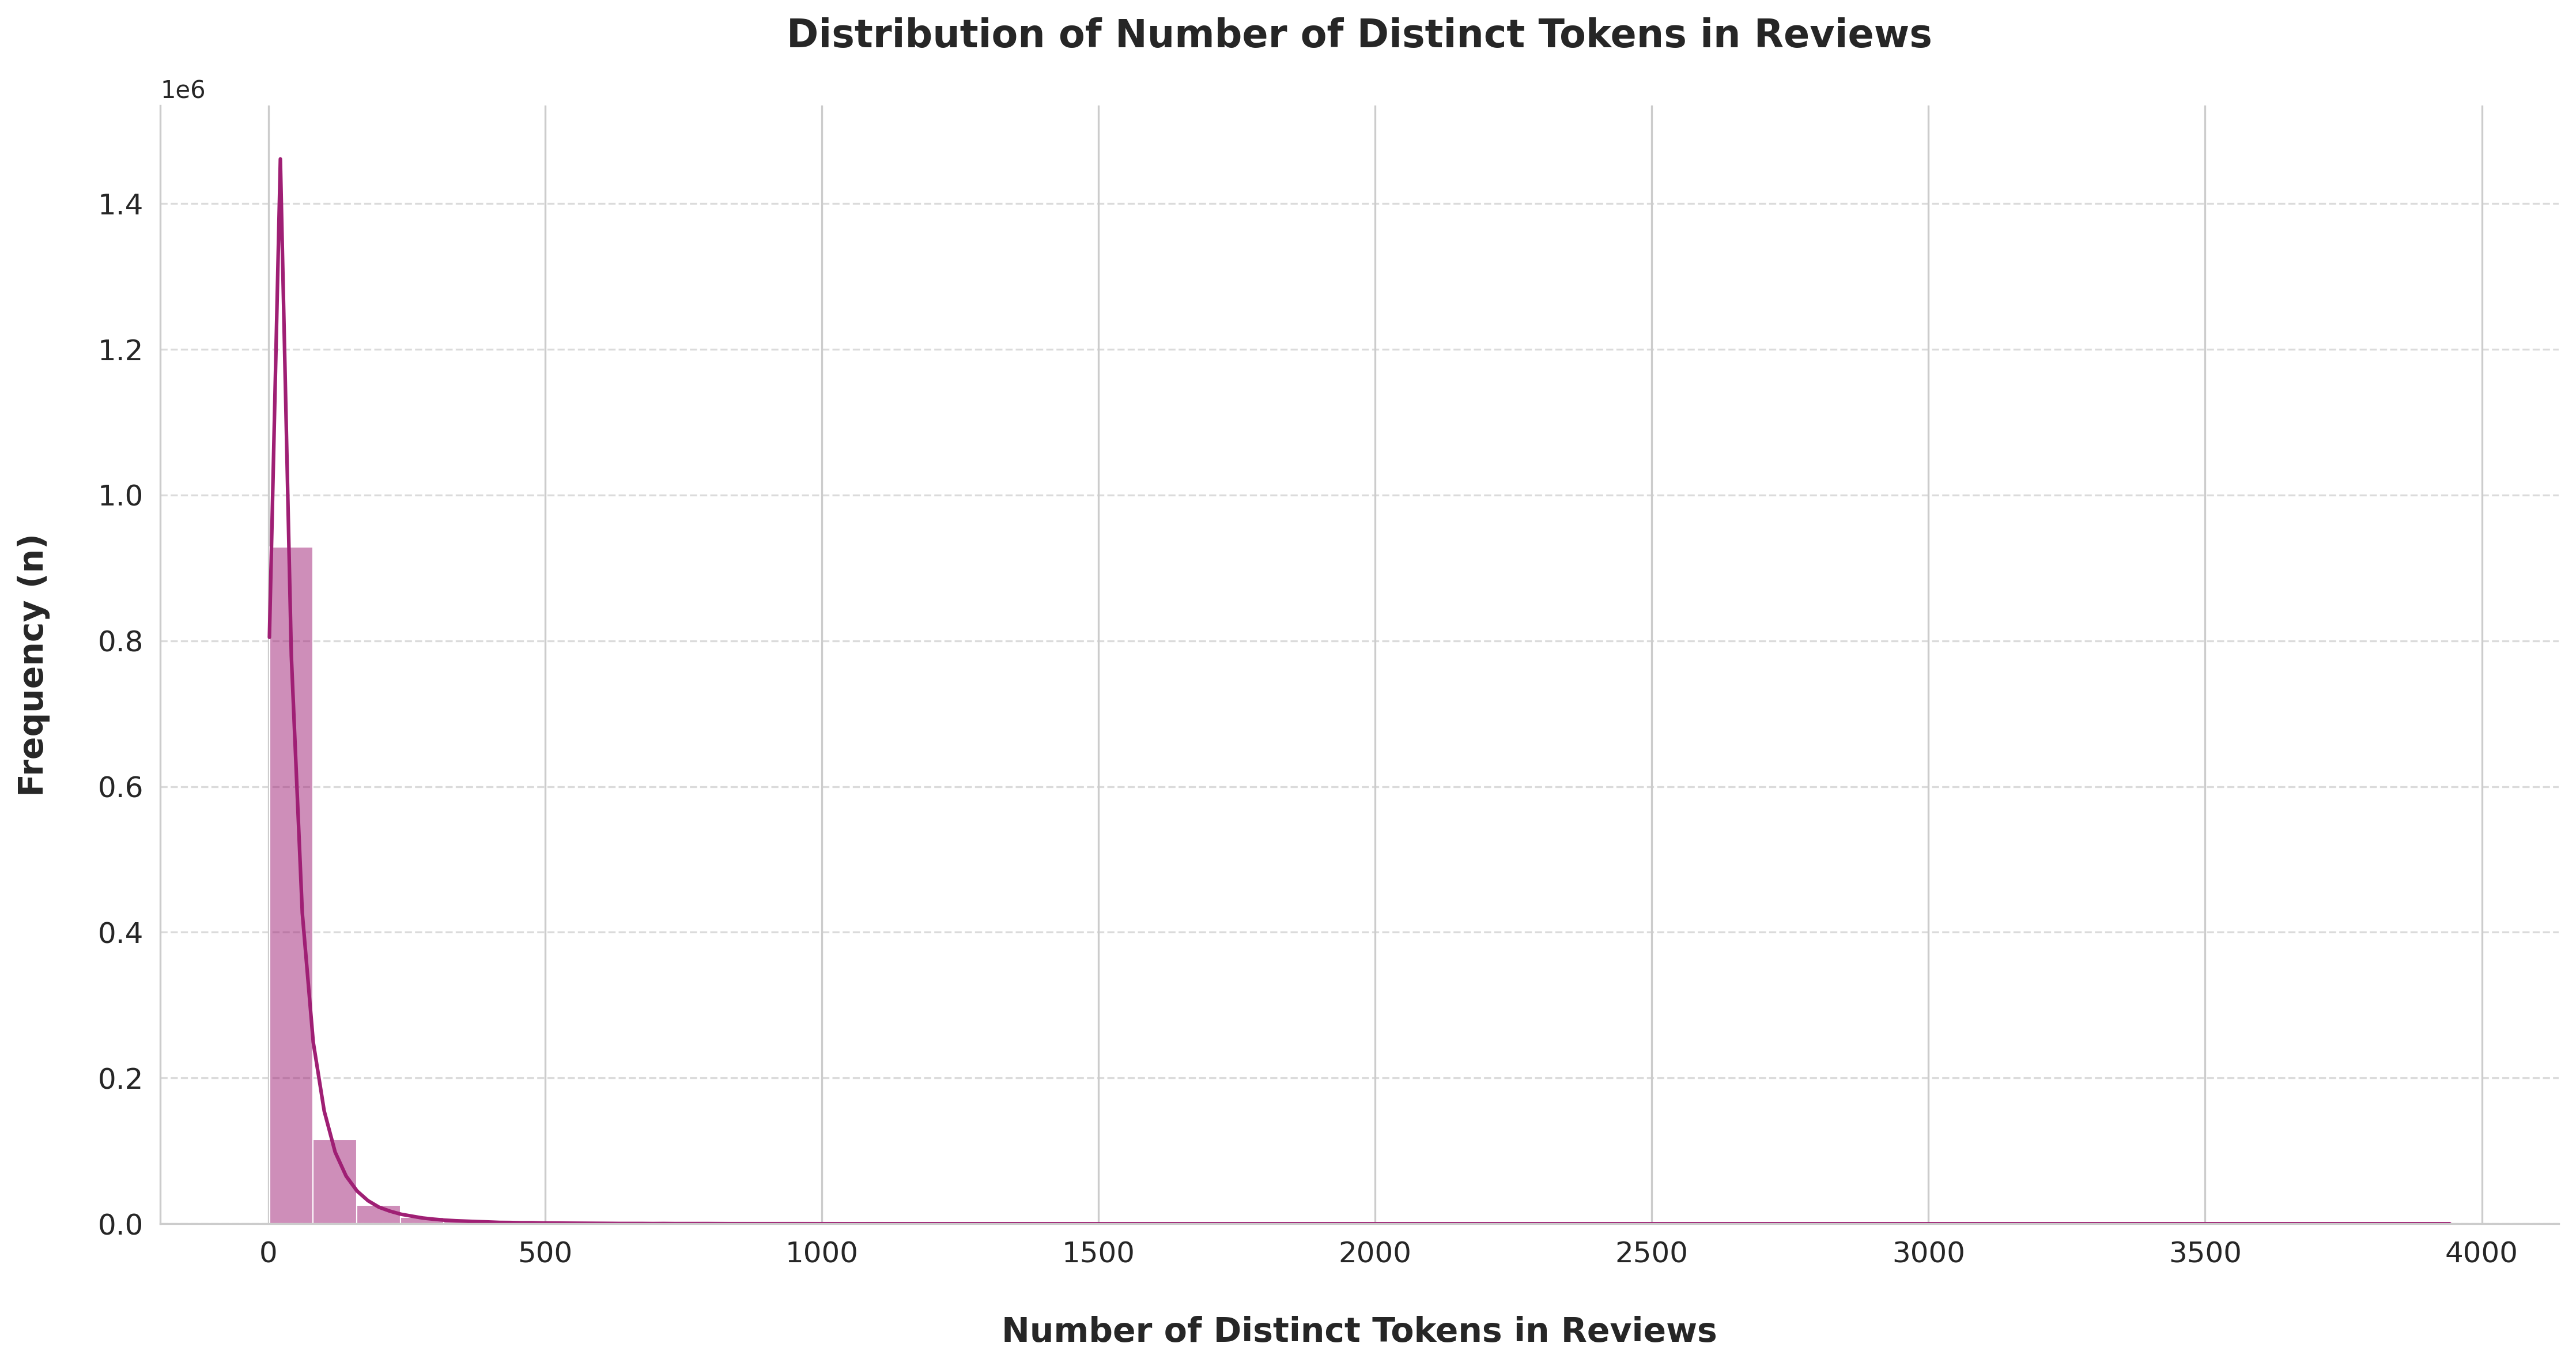

In [0]:
# Histogram of 'n_reviews_text' (Number of Words in Reviews)
plt.figure(figsize=(15, 8), dpi=300)
sns.histplot(
    reviews_df.select("n_reviews_text").toPandas(),
    x="n_reviews_text",
    bins=50,
    kde=True,
    color=color_palette[4],
    edgecolor="white",
    linewidth=0.5
)
plt.title("Distribution of Number of Distinct Tokens in Reviews\n", fontsize=16, fontweight='bold')
plt.xlabel("\nNumber of Distinct Tokens in Reviews", fontsize=14, fontweight='bold')
plt.ylabel("Frequency (n)\n", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove legend if it exists
if plt.gca().get_legend() is not None:
    plt.gca().get_legend().remove()

sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

### **🔂 Unigram and 🔗 Bigram Generation**

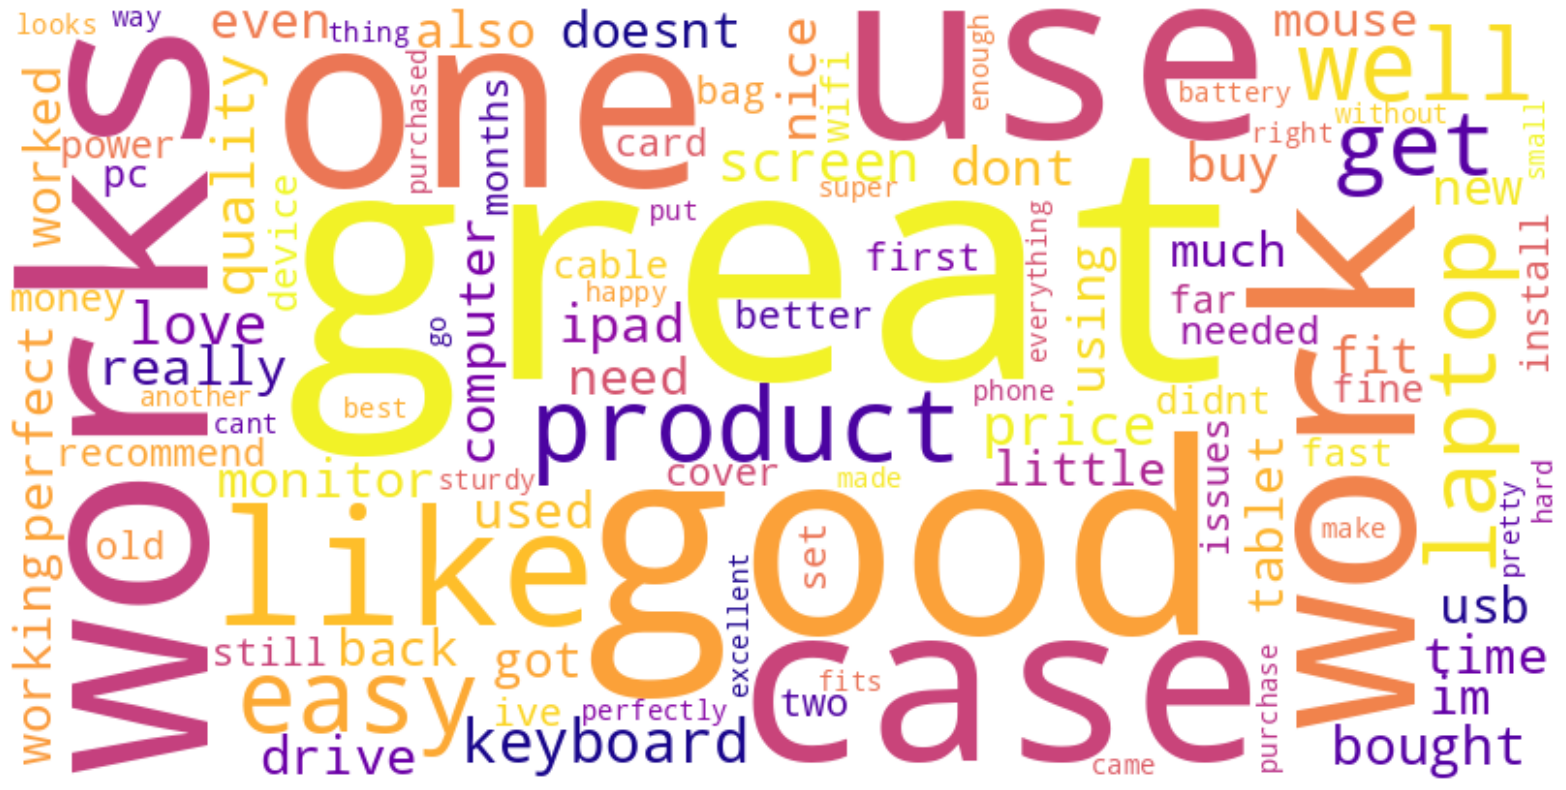


Time of Execution (Unigram WordCloud): 117.1897485256195 seconds (0:01:57.189749 h)


In [0]:
# Unigram WordCloud Generation
start_time = time.time()

# Collect only a limited number (e.g., 100) for visualization
top_n_unigrams = 100
top_unigrams_collected = sorted_token_counts_df.limit(top_n_unigrams).collect()

# Convert collected Rows into a dictionary
unigrams_freq_dict = {row['token']: row['frequency'] for row in top_unigrams_collected}

# WordCloud Generation (Unigrams)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma') \
                .generate_from_frequencies(unigrams_freq_dict)
plot_cloud(wordcloud)

# End timer and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution (Unigram WordCloud):\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)")

In [0]:
# WordCloud Generation (Bigram)
# Start timer
start_time = time.time()

# 1. Use the NGram transformer
#    inputCol should be the column containing the ARRAY of tokens
ngram_transformer_bi = NGram(n=2, inputCol="filtered_tokens_array", outputCol="bigrams_array")

# 2. Transform the DataFrame to add the bigram array column
bigrams_df = ngram_transformer_bi.transform(processed_df)

# 3. Explode the bigram array
#    Each element in 'bigrams_array' is a string like "word1 word2" by default
exploded_bigrams_df = bigrams_df.select(explode(col("bigrams_array")).alias("bigram")) \
                                .filter(col("bigram").isNotNull()) \
                                .filter(col("bigram") != "") \
                                .filter(~col("bigram").contains("  ")) \
                                .filter(F.length(col("bigram")) > 2) # Ensure bigram has meaningful length

# 4. Count bigram frequencies
bigram_counts_df = exploded_bigrams_df.groupBy("bigram").agg(count("*").alias("frequency"))

# 5. Order by frequency
sorted_bigram_counts_df = bigram_counts_df.orderBy(desc("frequency"))

# 6. Show top bigrams
unique_bigrams = sorted_bigram_counts_df.distinct().count()
print(f"\n\033[1mUnique Bigrams:\033[0m {unique_bigrams}")
print("\033[1mMost Common Bigrams:\033[0m")
sorted_bigram_counts_df.show(20, truncate=False)


Unique Bigrams: 5681837
Most Common Bigrams:
+----------------+---------+
|bigram          |frequency|
+----------------+---------+
|works great     |61438    |
| months         |31337    |
|easy use        |30393    |
|great product   |30119    |
|works well      |29917    |
|easy install    |27547    |
|stopped working |19158    |
|good quality    |18262    |
|highly recommend|17431    |
|windows         |16399    |
| years          |16007    |
|great price     |15992    |
|good product    |15471    |
|doesnt work     |15153    |
|great value     |14158    |
|hard drive      |13927    |
|customer service|13773    |
|screen protector|13720    |
|battery life    |12824    |
|works perfectly |12456    |
+----------------+---------+
only showing top 20 rows



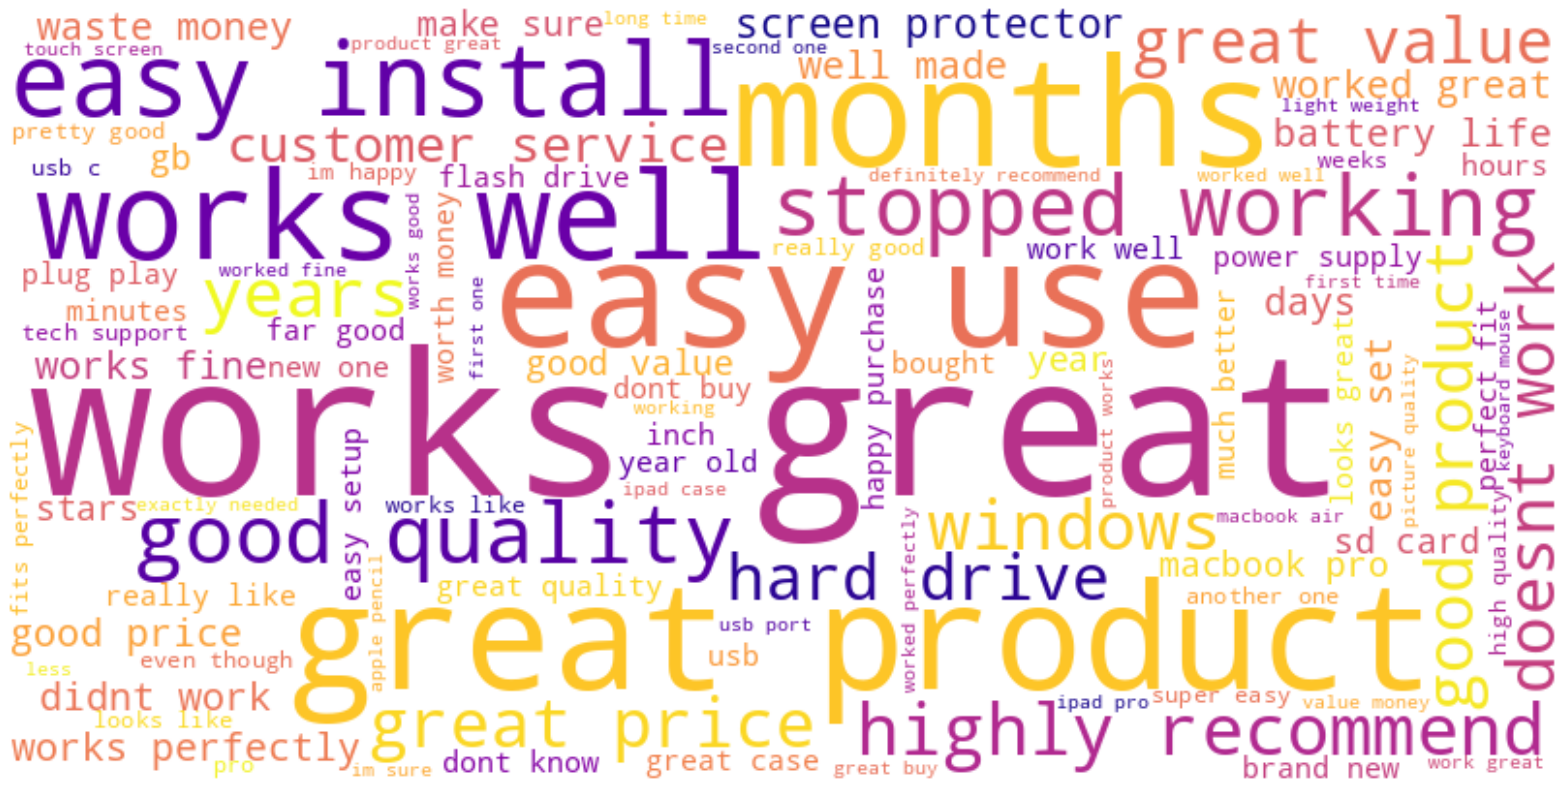


Time of Execution (Bigrams): 590.6128919124603 seconds (0:09:50.612892 h)


In [0]:
# 7. Collect top 100 bigrams for WordCloud
top_n_bigrams = 100
top_bigrams_collected = sorted_bigram_counts_df.limit(top_n_bigrams).collect()

# Convert collected Rows into a dictionary for WordCloud
bigram_freq_dict = {row['bigram']: row['frequency'] for row in top_bigrams_collected}

# WordCloud Generation (Bigram)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma') \
                .generate_from_frequencies(bigram_freq_dict)
plot_cloud(wordcloud)

# End timer and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution (Bigrams):\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)")

---